In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기

In [ ]:
# 1. 데이터 로드
load_path = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/'
file_path = load_path + 'gru_dataset.npz'

data = np.load(file_path)
X_raw = data['X']
y_raw = data['y']

print(f"전체 데이터 형태: X={X_raw.shape}, y={y_raw.shape}")

전체 데이터 형태: X=(362, 3, 24), y=(362,)


## 모델 학습

In [ ]:
# 분류
# 라벨 생성
y_class = (y_raw > 0).astype(int)

# Train/Test 분리
split_idx = int(len(X_raw) * 0.8)
X_train_c, X_test_c = X_raw[:split_idx], X_raw[split_idx:]
y_train_c, y_test_c = y_class[:split_idx], y_class[split_idx:]

print(f"학습 데이터(분류): {X_train_c.shape}, 정답 1의 개수: {sum(y_train_c)}")

# 모델
model_c = Sequential([
    GRU(32, input_shape=(X_train_c.shape[1], X_train_c.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_c.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history_c = model_c.fit(X_train_c, y_train_c, epochs=50, batch_size=2, validation_data=(X_test_c, y_test_c), verbose=0)

# 평가
pred_prob = model_c.predict(X_test_c)
pred_class = (pred_prob > 0.5).astype(int).flatten()
acc = accuracy_score(y_test_c, pred_class)

print(f"테스트 정확도: {acc*100:.2f}%")
print(f"1) 실제값: {y_test_c}")
print(f"2) 예측값: {pred_class}")

   - 학습 데이터(분류): (289, 3, 24), 정답 1의 개수: 10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
   Task 1 테스트 정확도: 47.95%
   - 실제값: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0]
   - 예측값: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# 회귀
# 지진이 발생한(규모 > 0) 샘플만 필터링
indices = np.where(y_raw > 0)[0]
X_reg_data = X_raw[indices]
y_reg_data = y_raw[indices]

# 데이터 적은지 체크
if len(X_reg_data) < 5:
    print("데이터가 적어 학습 어려움")
else:
    # Train/Test 분리
    split_r = int(len(X_reg_data) * 0.8)
    X_train_r, X_test_r = X_reg_data[:split_r], X_reg_data[split_r:]
    y_train_r, y_test_r = y_reg_data[:split_r], y_reg_data[split_r:]

    print(f"학습 데이터(회귀): {X_train_r.shape}")

    # 모델
    model_r = Sequential([
        GRU(64, input_shape=(X_train_r.shape[1], X_train_r.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    model_r.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # 학습
    history_r = model_r.fit(X_train_r, y_train_r, epochs=100, batch_size=1, validation_data=(X_test_r, y_test_r), verbose=0)

    # 평가
    pred_reg = model_r.predict(X_test_r).flatten()
    mse = mean_squared_error(y_test_r, pred_reg)

    print(f"테스트 MSE: {mse:.4f}")
    print(f"1) 실제 규모: {y_test_r}")
    print(f"2) 예측 규모: {np.round(pred_reg, 2)}")

   - 학습 데이터(회귀): (38, 3, 24)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
   Task 2 테스트 MSE: 0.3913
   - 실제 규모: [1.4 1.6 1.5 1.9 3.5 2.2 2.8 1.2 2.1 1.5]
   - 예측 규모: [1.81 1.81 1.93 2.13 2.28 2.27 2.27 2.25 2.25 2.24]


## 결과 시각화

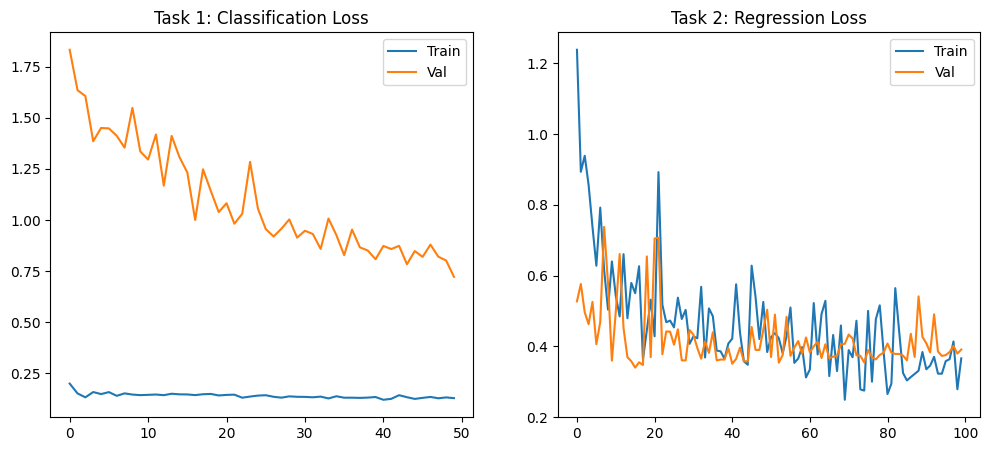

In [ ]:
plt.figure(figsize=(12, 5))

# 분류 Loss
plt.subplot(1, 2, 1)
plt.plot(history_c.history['loss'], label='Train')
plt.plot(history_c.history['val_loss'], label='Val')
plt.title('Task 1: Classification Loss')
plt.legend()

# 회귀 Loss
plt.subplot(1, 2, 2)
plt.plot(history_r.history['loss'], label='Train')
plt.plot(history_r.history['val_loss'], label='Val')
plt.title('Task 2: Regression Loss')
plt.legend()

plt.show()